# 08 - City Public Good Index

Combine all city-level criteria into a final City Public Good Index.

## Methodology (same CPI-style as state analysis)

1. **Normalize** each sub-metric using z-scores (mean ~45, std ~20, clamped [0, 100])
2. **Sub-metrics** (higher = better):
   - Tax efficiency: inverse of tax per capita (lower taxes = higher score)
   - Investment ratio: % of spending classified as investment
   - Service effectiveness: composite of education, safety, health
3. **Aggregate**: simple average of three normalized sub-scores

**Output:** `city_public_good.csv`, `city_public_good.json`

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from pathlib import Path

PROCESSED_DIR = Path("../data/processed")
CHARTS_DIR = Path("../docs/charts/data")
CHARTS_DIR.mkdir(parents=True, exist_ok=True)

In [2]:
def normalize_zscore(series, invert=False):
    """Normalize a series to 0-100 using z-score method (CPI-style)."""
    if invert:
        series = -series
    z = (series - series.mean()) / series.std()
    scaled = z * 20 + 45
    return scaled.clip(0, 100)

In [3]:
# Load outputs from notebooks 05-07
tax = pd.read_csv(PROCESSED_DIR / "city_tax_burden.csv")
spending = pd.read_csv(PROCESSED_DIR / "city_spending.csv")
effectiveness = pd.read_csv(PROCESSED_DIR / "city_effectiveness.csv")

print(f"Tax burden:    {len(tax)} cities")
print(f"Spending:      {len(spending)} cities")
print(f"Effectiveness: {len(effectiveness)} cities")

Tax burden:    100 cities
Spending:      100 cities
Effectiveness: 100 cities


In [4]:
# Merge all sub-metrics
combined = tax[["city", "city_state", "state", "population", "lat", "lon", "tax_per_capita"]].merge(
    spending[["city_state", "investment_per_capita"]], on="city_state", how="inner"
).merge(
    effectiveness[["city_state", "composite_score"]], on="city_state", how="inner"
)

# Normalize each sub-metric (CPI-style)
# tax_per_capita and investment_per_capita are already COL-adjusted from notebooks 05/06
combined["tax_score"] = normalize_zscore(combined["tax_per_capita"], invert=True)
combined["investment_score"] = normalize_zscore(combined["investment_per_capita"])
combined["effectiveness_score"] = normalize_zscore(combined["composite_score"])

# City Public Good Index = simple average
combined["city_pgi"] = (
    combined["tax_score"]
    + combined["investment_score"]
    + combined["effectiveness_score"]
) / 3

# Rank (1 = best)
combined["rank"] = combined["city_pgi"].rank(ascending=False).astype(int)

print(f"Cities: {len(combined)}")
print(f"City PGI range: {combined['city_pgi'].min():.1f}/100 – {combined['city_pgi'].max():.1f}/100")
print(f"Mean: {combined['city_pgi'].mean():.1f}/100, Median: {combined['city_pgi'].median():.1f}/100")

# Display top 10
display_df = combined[["city_state", "rank", "tax_score", "investment_score",
                        "effectiveness_score", "city_pgi"]].copy()
for col in ["tax_score", "investment_score", "effectiveness_score", "city_pgi"]:
    display_df[col] = display_df[col].apply(lambda x: f"{x:.1f}/100")
display_df.sort_values("rank").head(10)

Cities: 100
City PGI range: 27.7/100 – 62.7/100
Mean: 45.0/100, Median: 44.5/100


,city_state,rank,tax_score,investment_score,effectiveness_score,city_pgi
38,"Irvine, CA",1,56.4/100,38.9/100,92.8/100,62.7/100
85,"Scottsdale, AZ",2,52.5/100,42.8/100,86.1/100,60.5/100
86,"Seattle, WA",3,28.8/100,70.8/100,77.7/100,59.1/100
82,"San Francisco, CA",4,0.0/100,100.0/100,75.8/100,58.6/100
30,"Gilbert, AZ",5,63.6/100,30.8/100,78.8/100,57.8/100
27,"Fremont, CA",6,61.4/100,27.7/100,82.3/100,57.1/100
72,"Plano, TX",7,51.8/100,39.8/100,77.7/100,56.4/100
5,"Austin, TX",8,46.1/100,50.3/100,69.3/100,55.2/100
51,"Madison, WI",9,35.3/100,48.7/100,80.8/100,54.9/100
74,"Raleigh, NC",10,54.4/100,41.4/100,68.9/100,54.9/100


In [5]:
# Export results
score_cols = ["city", "city_state", "state", "population", "lat", "lon", "rank",
              "tax_score", "investment_score", "effectiveness_score", "city_pgi"]
scores = combined[score_cols].sort_values("rank").reset_index(drop=True)

csv_path = PROCESSED_DIR / "city_public_good.csv"
scores.to_csv(csv_path, index=False)
print(f"Wrote {csv_path}")

json_path = CHARTS_DIR / "city_public_good.json"
scores.to_json(json_path, orient="records", indent=2)
print(f"Wrote {json_path}")

# Detailed output with raw values
detail_cols = ["city", "city_state", "state", "population", "lat", "lon", "rank",
               "tax_per_capita", "investment_per_capita", "composite_score",
               "tax_score", "investment_score", "effectiveness_score", "city_pgi"]
detailed = combined[detail_cols].sort_values("rank").reset_index(drop=True)
detail_path = PROCESSED_DIR / "city_public_good_detailed.csv"
detailed.to_csv(detail_path, index=False)
print(f"Wrote {detail_path}")

Wrote ../data/processed/city_public_good.csv
Wrote ../docs/charts/data/city_public_good.json
Wrote ../data/processed/city_public_good_detailed.csv


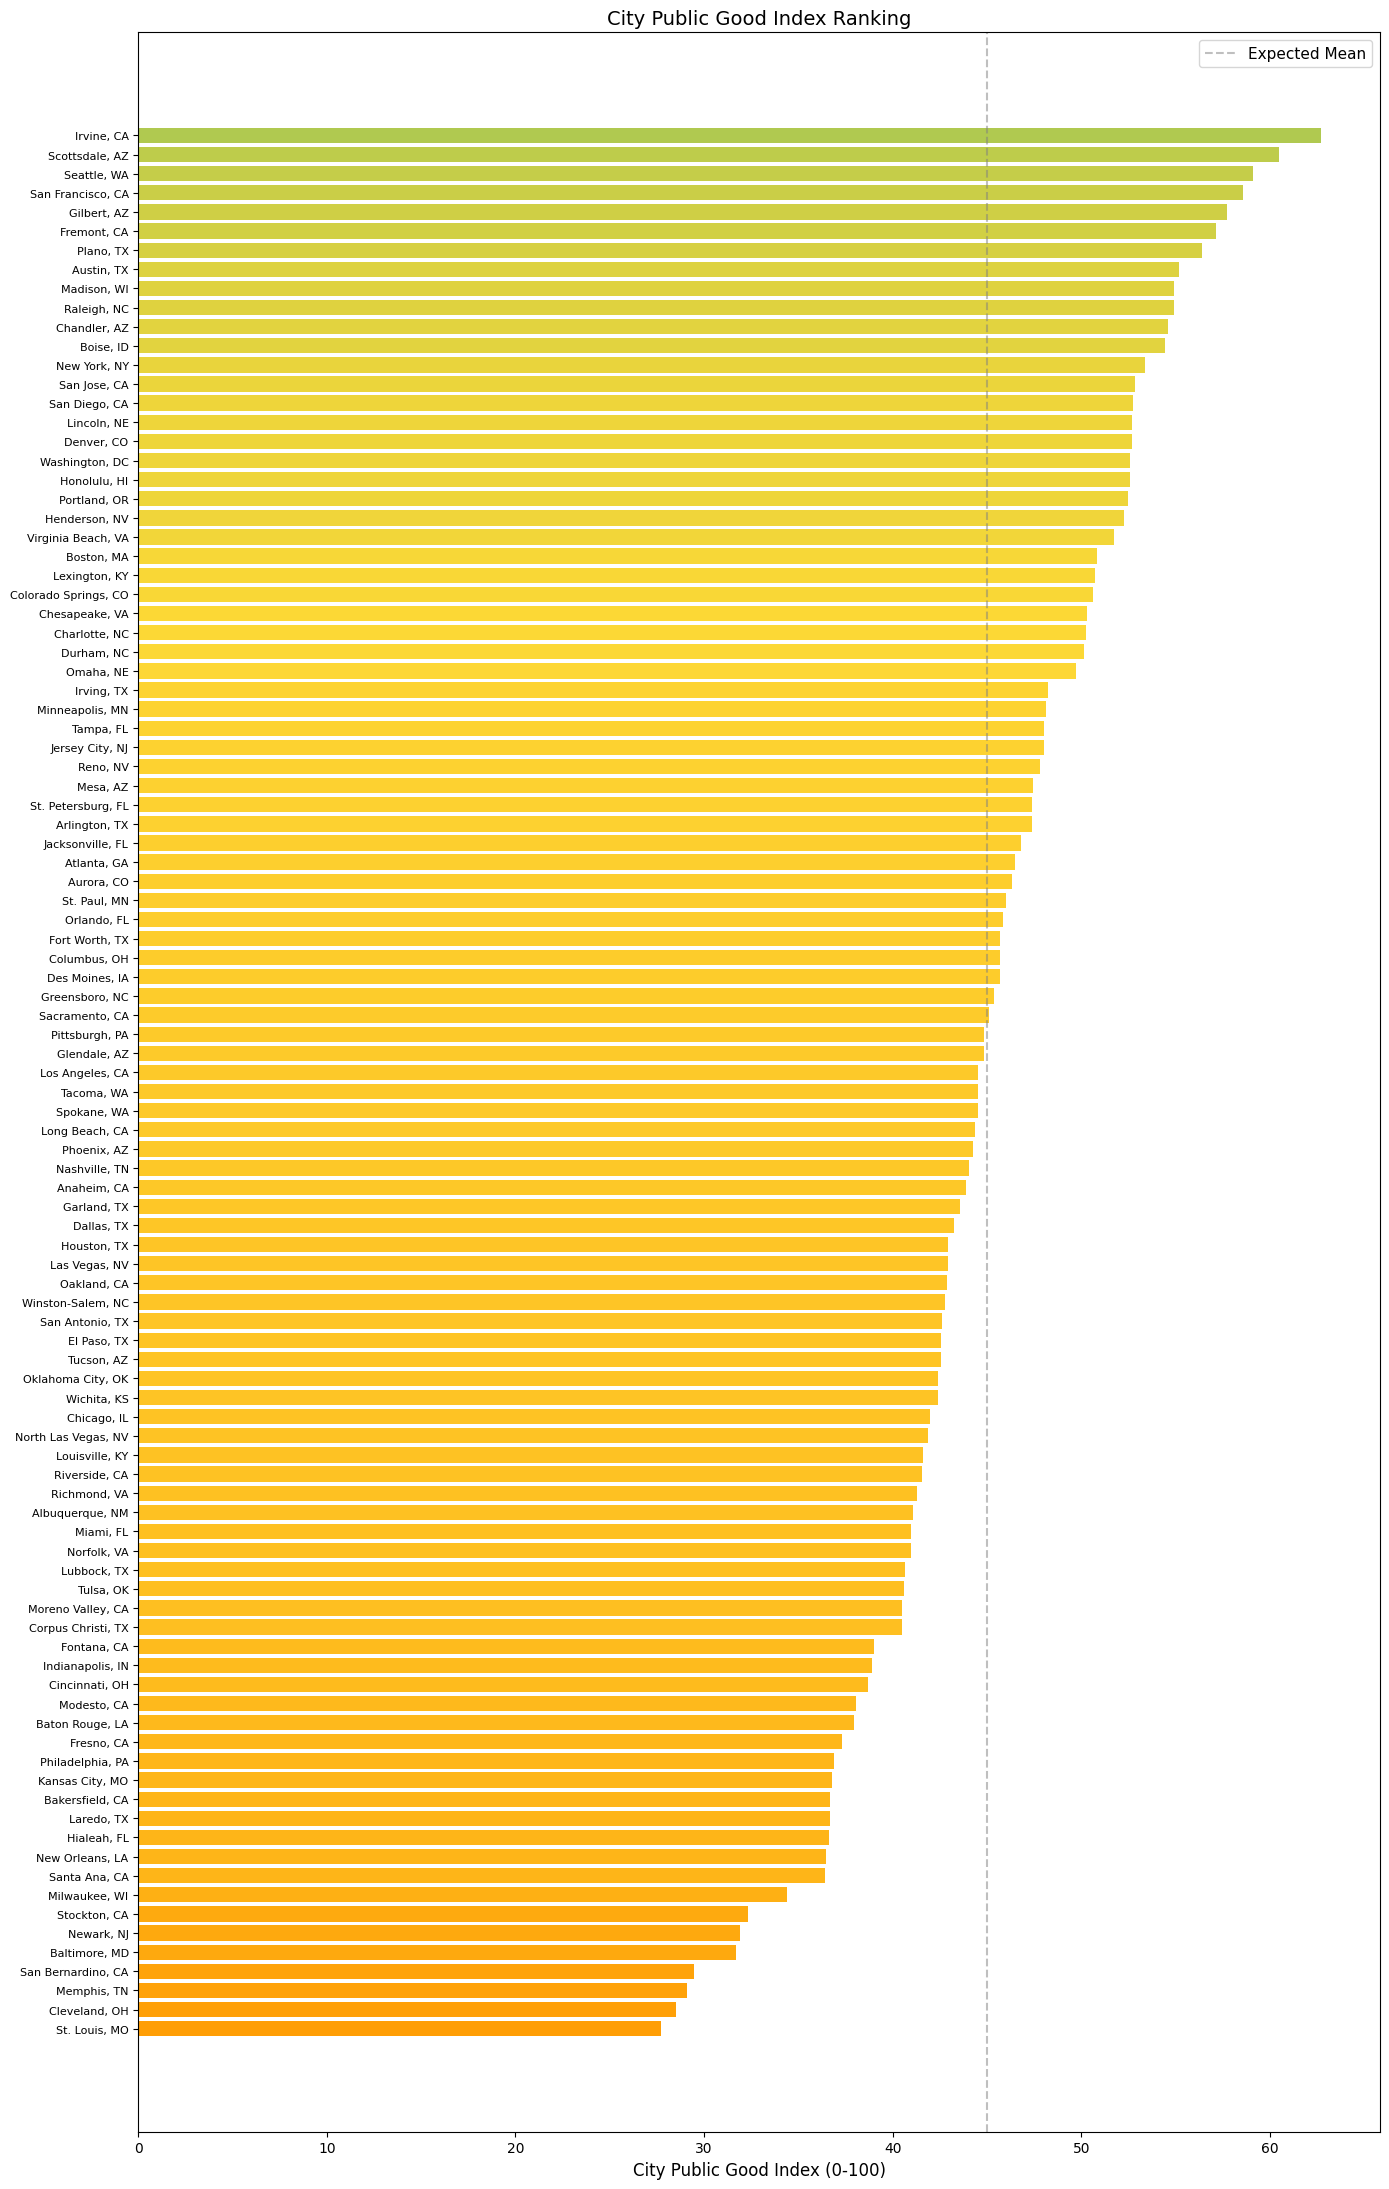

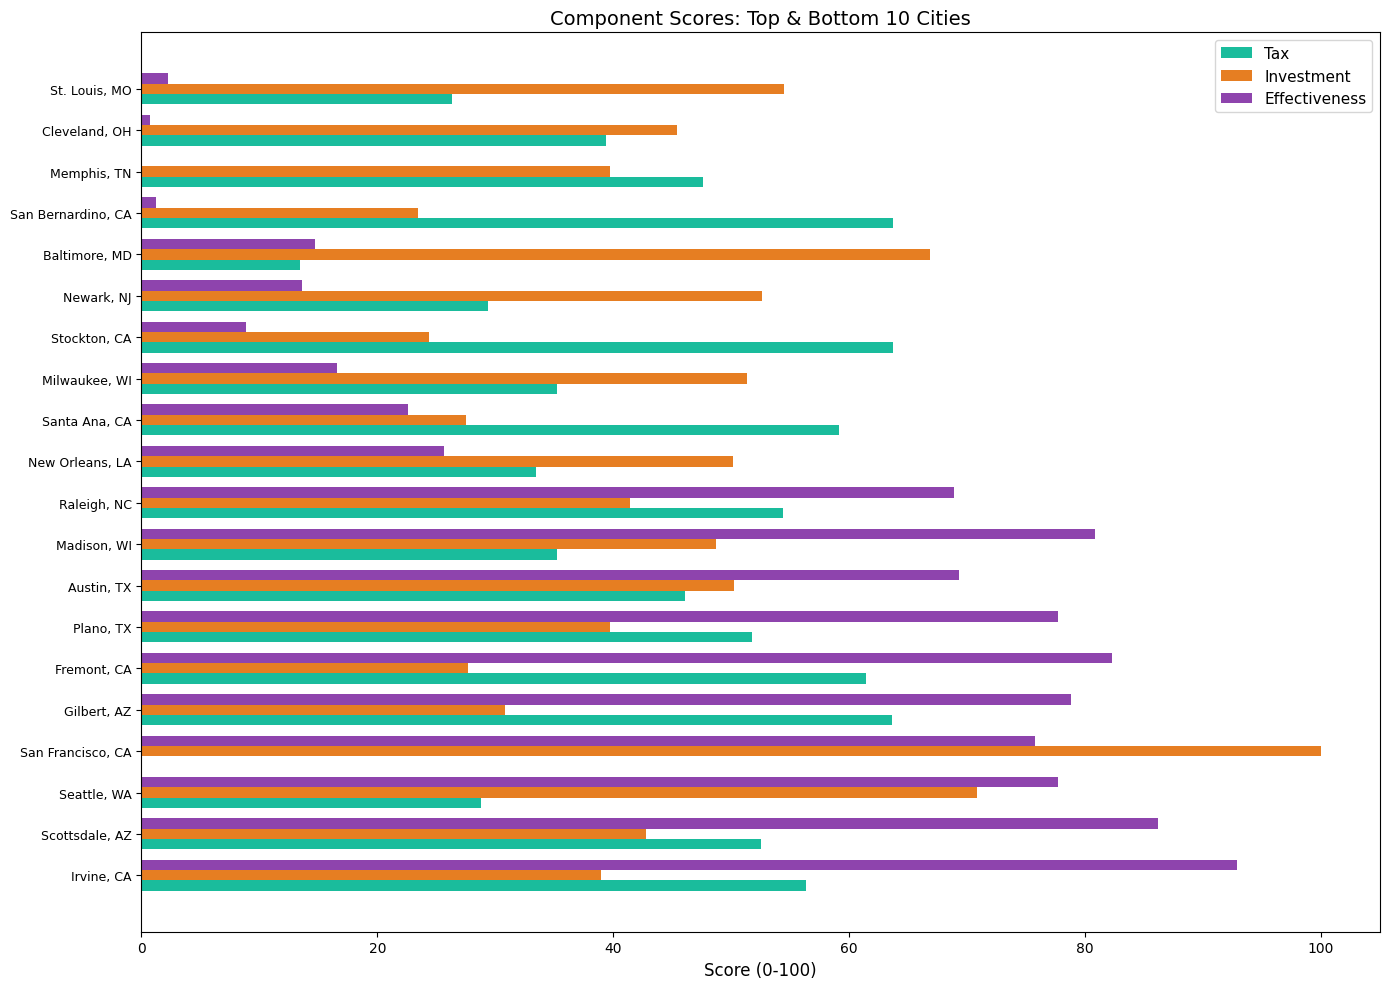

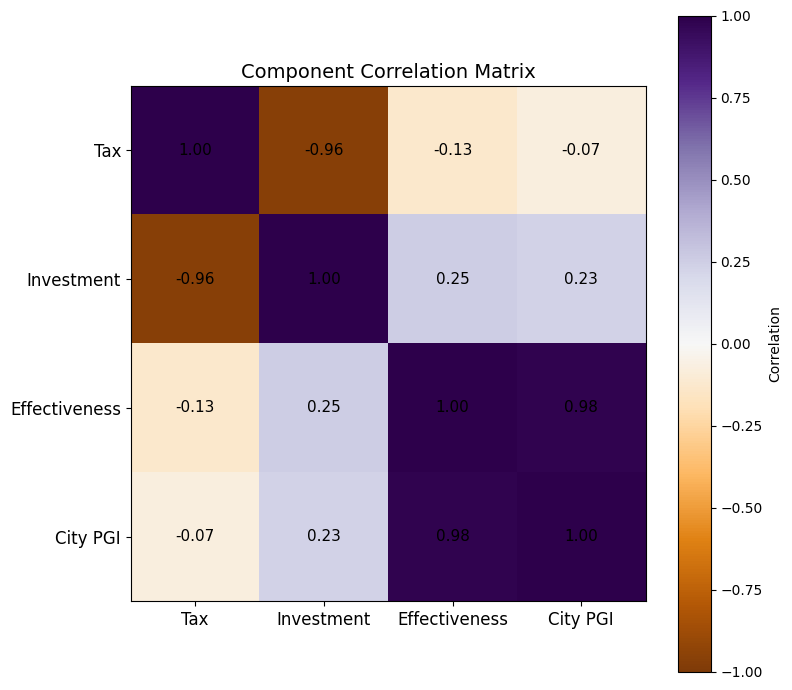

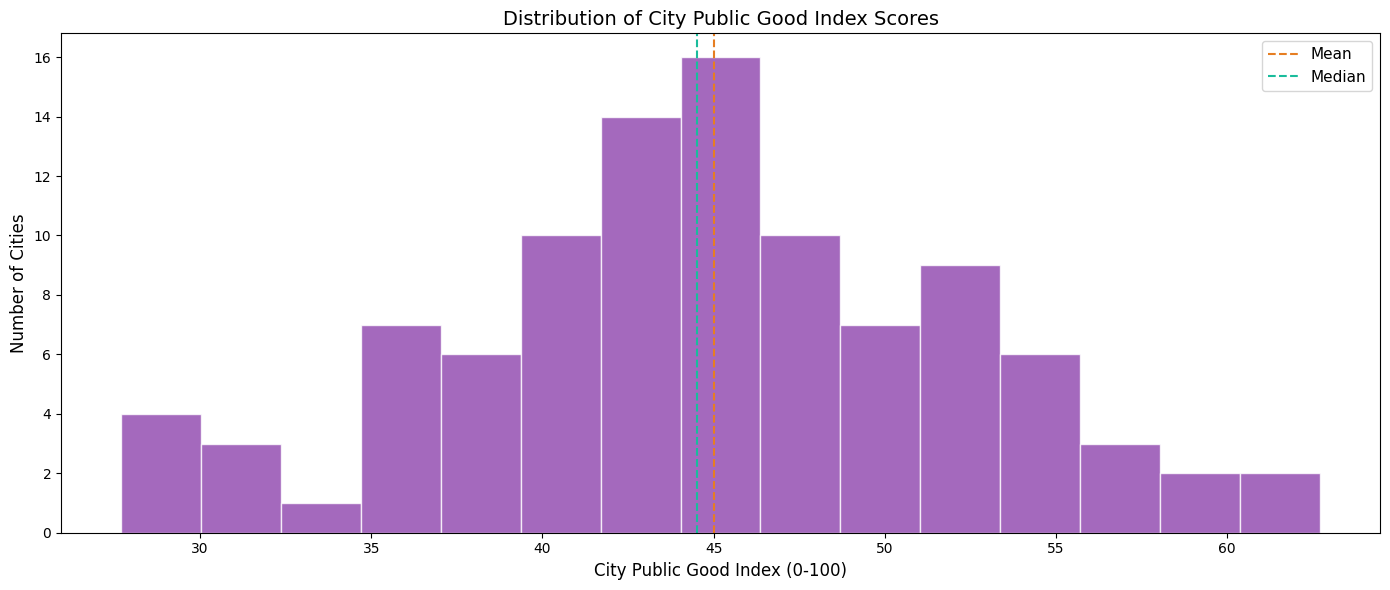

In [6]:
from matplotlib.colors import LinearSegmentedColormap
SCORE_CMAP = LinearSegmentedColormap.from_list("score", ["#d32f2f", "#ff9800", "#fdd835", "#66bb6a", "#2e7d32"])

# 1. Ranking bar chart
fig, ax = plt.subplots(figsize=(14, 22))
plot_data = scores.sort_values("city_pgi", ascending=True)
colors = SCORE_CMAP(plot_data["city_pgi"] / 100)
ax.barh(plot_data["city_state"], plot_data["city_pgi"], color=colors)
ax.set_xlabel("City Public Good Index (0-100)", fontsize=12)
ax.set_title("City Public Good Index Ranking", fontsize=14)
ax.axvline(x=45, color="gray", linestyle="--", alpha=0.5, label="Expected Mean")
ax.tick_params(axis="y", labelsize=8)
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

# 2. Component comparison (top/bottom 10)
fig, ax = plt.subplots(figsize=(14, 10))
top_bottom = pd.concat([scores.head(10), scores.tail(10)])
x = range(len(top_bottom))
w = 0.25
ax.barh([i - w for i in x], top_bottom["tax_score"], height=w, label="Tax", color="#1abc9c")
ax.barh(x, top_bottom["investment_score"], height=w, label="Investment", color="#e67e22")
ax.barh([i + w for i in x], top_bottom["effectiveness_score"], height=w, label="Effectiveness", color="#8e44ad")
ax.set_yticks(list(x))
ax.set_yticklabels(top_bottom["city_state"], fontsize=9)
ax.set_xlabel("Score (0-100)", fontsize=12)
ax.set_title("Component Scores: Top & Bottom 10 Cities", fontsize=14)
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

# 3. Correlation matrix
fig, ax = plt.subplots(figsize=(8, 7))
corr_cols = ["tax_score", "investment_score", "effectiveness_score", "city_pgi"]
corr = combined[corr_cols].corr()
im = ax.imshow(corr, cmap="PuOr", vmin=-1, vmax=1)
ax.set_xticks(range(len(corr_cols)))
ax.set_yticks(range(len(corr_cols)))
labels = ["Tax", "Investment", "Effectiveness", "City PGI"]
ax.set_xticklabels(labels, fontsize=12)
ax.set_yticklabels(labels, fontsize=12)
for i in range(len(corr_cols)):
    for j in range(len(corr_cols)):
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}", ha="center", va="center", fontsize=11)
plt.colorbar(im, ax=ax, label="Correlation")
ax.set_title("Component Correlation Matrix", fontsize=14)
plt.tight_layout()
plt.show()

# 4. Histogram of PGI scores
fig, ax = plt.subplots(figsize=(14, 6))
ax.hist(scores["city_pgi"], bins=15, color="#8e44ad", edgecolor="white", alpha=0.8)
ax.axvline(x=scores["city_pgi"].mean(), color="#e67e22", linestyle="--", label="Mean")
ax.axvline(x=scores["city_pgi"].median(), color="#1abc9c", linestyle="--", label="Median")
ax.set_xlabel("City Public Good Index (0-100)", fontsize=12)
ax.set_ylabel("Number of Cities", fontsize=12)
ax.set_title("Distribution of City Public Good Index Scores", fontsize=14)
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

In [7]:
import plotly.express as px

SCORE_SCALE = [[0, "#d32f2f"], [0.25, "#ff9800"], [0.5, "#fdd835"], [0.75, "#66bb6a"], [1, "#2e7d32"]]

# Overall PGI map
fig = px.scatter_geo(
    scores,
    lat="lat",
    lon="lon",
    color="city_pgi",
    size="population",
    color_continuous_scale=SCORE_SCALE,
    range_color=[0, 100],
    scope="usa",
    hover_name="city_state",
    hover_data={
        "lat": False,
        "lon": False,
        "rank": True,
        "city_pgi": ":.1f",
        "tax_score": ":.1f",
        "investment_score": ":.1f",
        "effectiveness_score": ":.1f",
        "population": ":,.0f",
    },
    labels={
        "city_pgi": "City PGI (0-100)",
        "tax_score": "Tax Score",
        "investment_score": "Investment Score",
        "effectiveness_score": "Effectiveness Score",
        "population": "Population",
    },
    title="City Public Good Index \u2014 Overall Score",
    size_max=30,
)
fig.update_layout(
    coloraxis_colorbar=dict(title="City PGI"),
    geo=dict(lakecolor="rgb(255,255,255)"),
)
fig.show()

In [8]:
# Subcategory maps \u2014 Tax, Investment, Effectiveness scores
for col, title in [
    ("tax_score", "Tax Score"),
    ("investment_score", "Investment Score"),
    ("effectiveness_score", "Effectiveness Score"),
]:
    fig = px.scatter_geo(
        scores,
        lat="lat",
        lon="lon",
        color=col,
        size="population",
        color_continuous_scale=SCORE_SCALE,
        range_color=[0, 100],
        scope="usa",
        hover_name="city_state",
        hover_data={
            "lat": False,
            "lon": False,
            col: ":.1f",
            "population": ":,.0f",
        },
        labels={col: f"{title} (0-100)", "population": "Population"},
        title=f"City Public Good Index \u2014 {title}",
        size_max=30,
    )
    fig.update_layout(
        coloraxis_colorbar=dict(title=title),
        geo=dict(lakecolor="rgb(255,255,255)"),
    )
    fig.show()

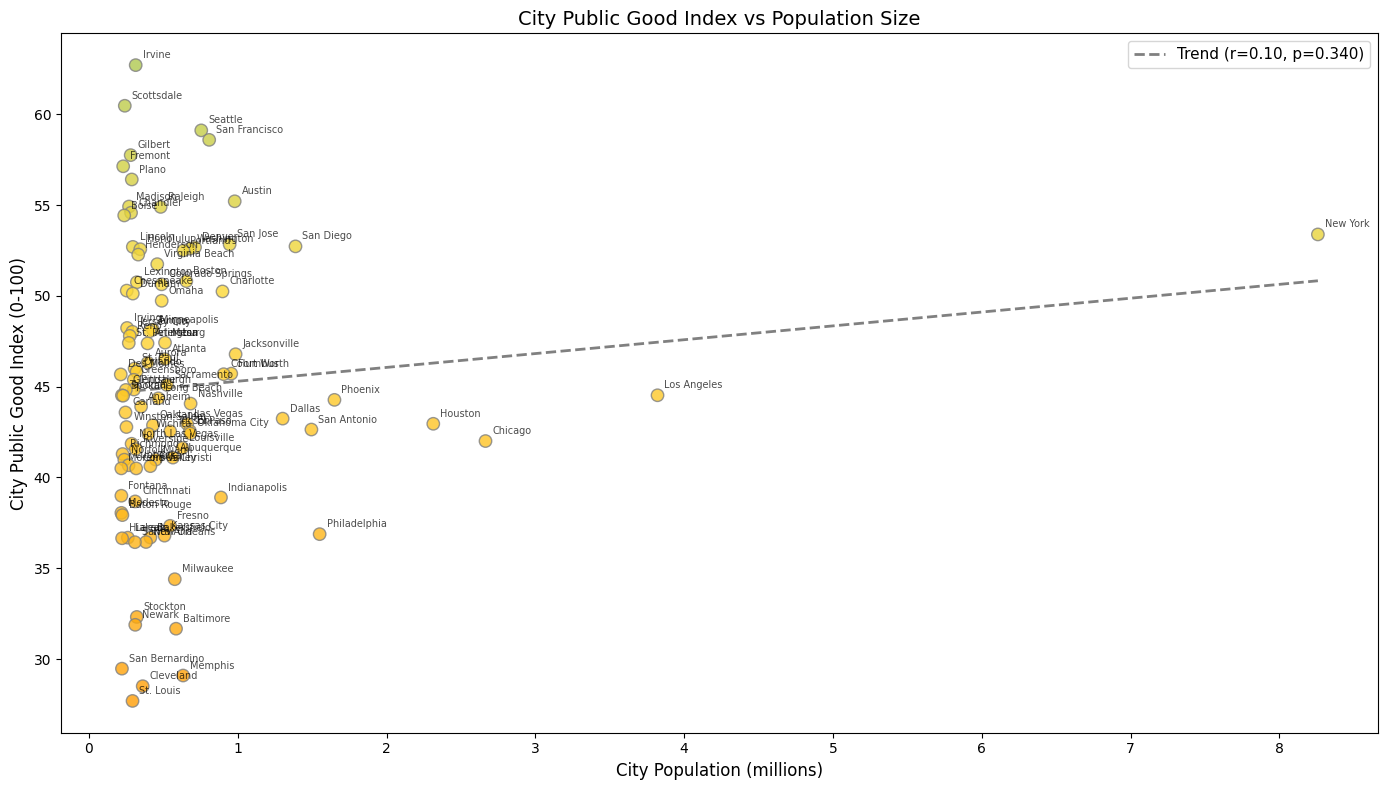

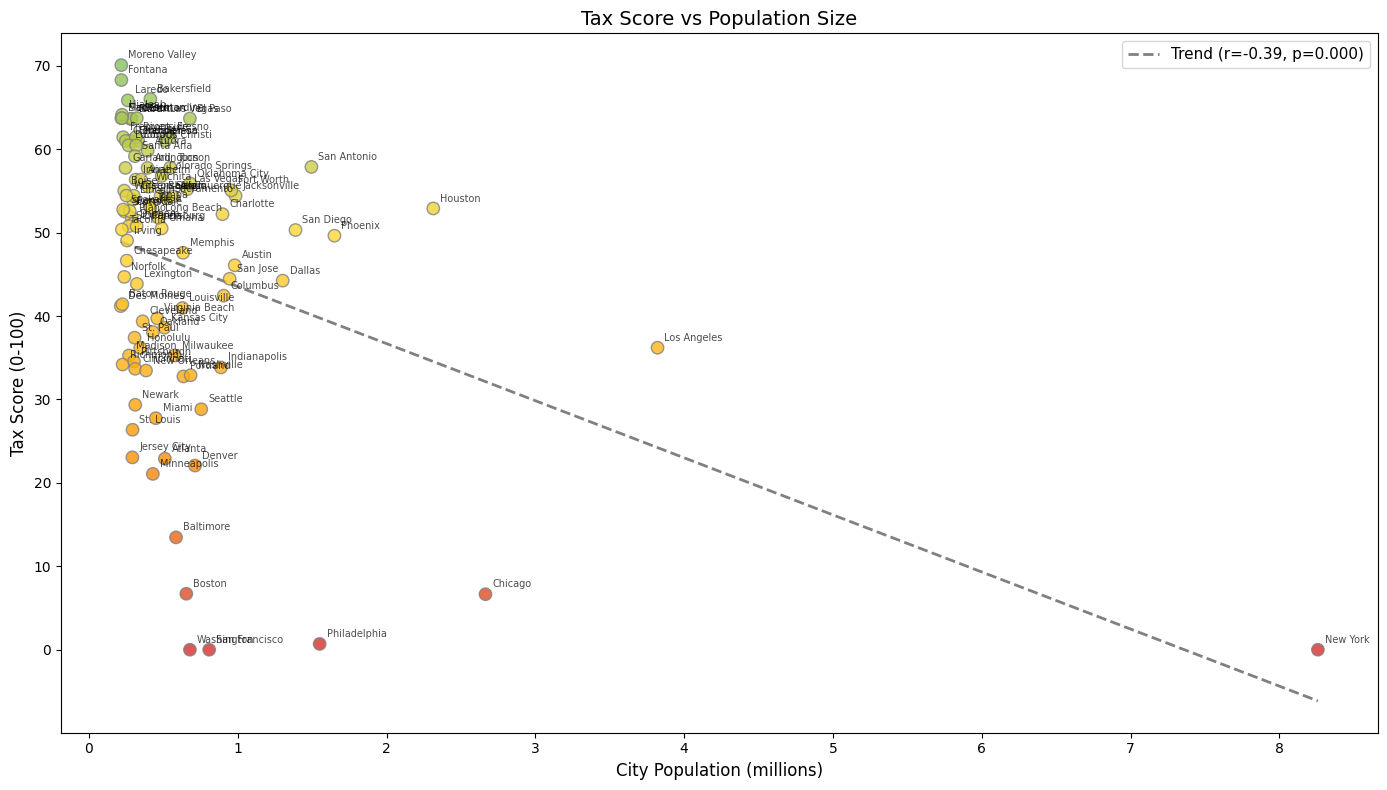

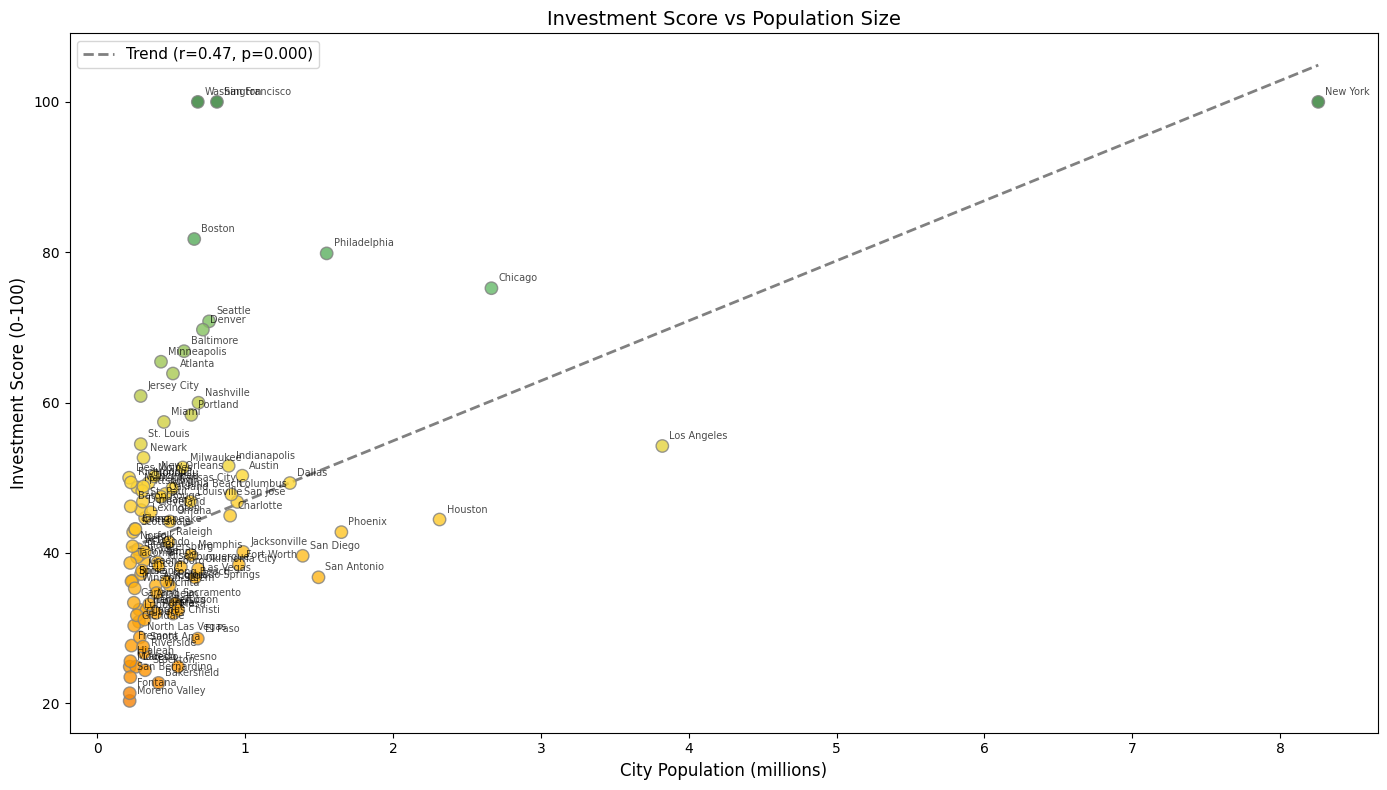

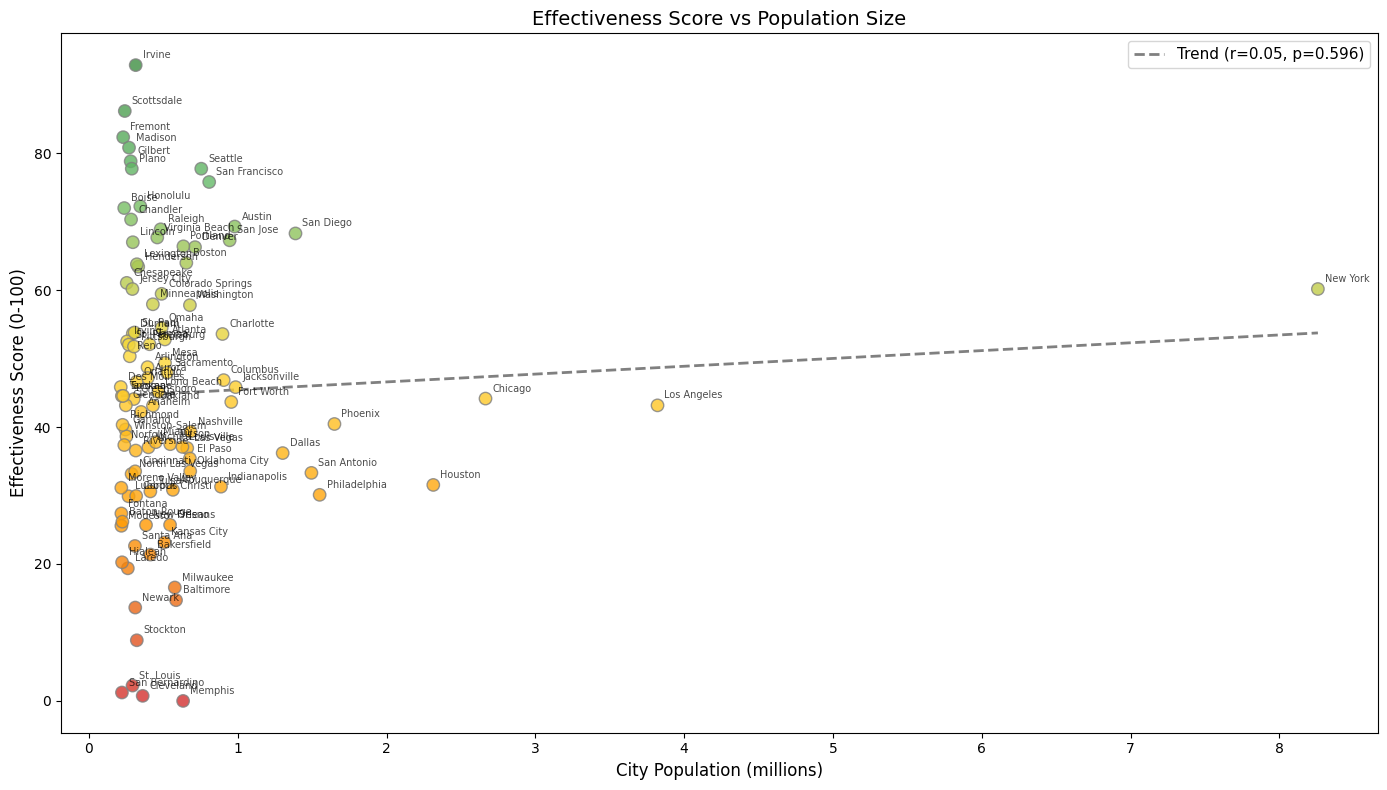

In [9]:
# Scatter plots \u2014 Population vs each score (with trend lines)
from scipy import stats

scatter_df = scores.copy()
scatter_df["pop_millions"] = scatter_df["population"] / 1e6

score_cols = [
    ("city_pgi", "City Public Good Index"),
    ("tax_score", "Tax Score"),
    ("investment_score", "Investment Score"),
    ("effectiveness_score", "Effectiveness Score"),
]

for col, label in score_cols:
    fig, ax = plt.subplots(figsize=(14, 8))

    ax.scatter(scatter_df["pop_millions"], scatter_df[col],
               c=scatter_df[col], cmap=SCORE_CMAP, s=80, alpha=0.8,
               edgecolors="gray", zorder=3, vmin=0, vmax=100)

    for _, row in scatter_df.iterrows():
        ax.annotate(row["city_state"].split(",")[0], (row["pop_millions"], row[col]),
                     fontsize=7, alpha=0.7, textcoords="offset points",
                     xytext=(5, 5))

    slope, intercept, r_value, p_value, std_err = stats.linregress(
        scatter_df["pop_millions"], scatter_df[col])
    x_line = np.linspace(scatter_df["pop_millions"].min(), scatter_df["pop_millions"].max(), 100)
    ax.plot(x_line, slope * x_line + intercept, color="gray", linestyle="--", linewidth=2,
            label=f"Trend (r={r_value:.2f}, p={p_value:.3f})")

    ax.set_xlabel("City Population (millions)", fontsize=12)
    ax.set_ylabel(f"{label} (0-100)", fontsize=12)
    ax.set_title(f"{label} vs Population Size", fontsize=14)
    ax.legend(fontsize=11)
    plt.tight_layout()
    plt.show()